# meta-VQE

Hot to obtain a Potential Energy Surface (PES) plot without training for *all* the points of interest.

## Keypoints

* For a molecule, the Hamiltonian depends on the geometry (separation) of the atoms or nuclei
* For simple, vanilla VQE, all the possible configurations (separations) in the molecule need to be trained separately
* meta-VQE trains a few points (training points), encoding the original parameters $\vec{\theta}$ using metaparamers and a linear or Gaussian encoding.

The code below uses Catalyst (from Xanadu) and JAX to optimize calculations

In [1]:
import catalyst
from catalyst import qjit

import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import minimize, OptimizeResult

import jax.numpy as jnp

# IMport custom optimizers

from custom_optimizers import ham_adam

In [2]:
## Layers and wires for circuits

symbols = ["H", "H"]
coordinates = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 1.0])

# Building the molecular hamiltonian for LiH
hamiltonian, qubits = qml.qchem.molecular_hamiltonian(
    symbols,
    coordinates,
    method="pyscf",
)

LAYERS = 3
WIRES = qubits

## https://docs.pennylane.ai/projects/catalyst/en/latest/code/api/catalyst.grad.html - ["fd", "defer"]
GRADIENT_METHOD= "fd"

TRAINING_ENERGIES= {"gradient_descent":{"energies":[], "trained_meta_vars":[], "runs_per_step":[]},
                    "spsa":{"energies":[], "trained_meta_vars":[], "runs_per_step":[]},
                    "adam":{"energies":[], "trained_meta_vars":[], "runs_per_step":[]},
                   }

gradient_methods = {"fd":"finite-diff", "ps":"parameter-shift"}

# Encoder: 
# Linear -> 1
# Gaussian -> 2

ENCODER_MULTIPLIER_DICT = {1:2,
                      2:4}

ENCODER = 2

shared_dev = qml.device("lightning.qubit", wires=WIRES)

train_points_indexes = [2,6,10,14,18]

test_points = np.arange(0.6,5,0.2)

train_points = np.array([test_points[i] for i in train_points_indexes])

test_hamiltonians = []

for d in test_points:
    coordinates = np.array([0.0, 0.0, 0.0, 0.0, 0.0, d]) 
    
    hamiltonian, _ = qml.qchem.molecular_hamiltonian(
        symbols,
        coordinates,
        method="pyscf",
    )    
    
    test_hamiltonians.append(hamiltonian)
    
print("===== TRAIN POINTS =====")
print(train_points)

===== TRAIN POINTS =====
[1.  1.8 2.6 3.4 4.2]


In [3]:
np.arange(0.6,5,0.2)

tensor([0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ,
        3.2, 3.4, 3.6, 3.8, 4. , 4.2, 4.4, 4.6, 4.8], requires_grad=True)

In [4]:
np.array(1.8)

tensor(1.8, requires_grad=True)

In [5]:
## Get Full COnfiguration Integration (FCI) data to compare
## Notice there are several ways to run FCI in pyscf: https://pyscf.org/user/ci.html
import pyscf
fci_energies = []

for d in test_points:
    mol = pyscf.M(
    atom = 'H 0 0 0; H 0 0 {0}'.format(d),
    basis = 'sto3g',
    unit="Bohr",       charge= 0,
    spin= 0   , verbose = False
    )

    myhf = mol.RHF().run()

    cisolver = pyscf.fci.FCI(myhf)
    fci_energies.append(cisolver.kernel()[0])

### Linear Encoding

$\theta_{i} = w_{i} \, R + \phi_{i}$

In [6]:
def linear_encoding(param_array, r):
    """1-D array with alphas and betas. len(param_array) = 2 * len(weights) 

    Args:
        param_array (float): alphas and betas for lineasr encoding
        r(float): Hamiltonian parameter (in this case, distance)
    """
    return param_array[::2]*r + param_array[1::2]

### Gaussian Encoding

$\theta_{i} = \alpha_{i} e^{\beta_{i} (\gamma_{i} - R)} + \delta_{i}$

In [7]:
def gaussian_encoding(param_array, r):
    """1-D array with alphas, betas, gammas and deltas. len(param_array) = 4 * len(weights) 

    Args:
        param_array (float): , betas, gammas and deltas for gaussian encoding
        r(float): Hamiltonian parameter (in this case, distance)
    """

    exp_arg = param_array[1::4]*(param_array[2::4] - r)

    return param_array[::4]*jnp.exp(exp_arg) + param_array[3::4]

In [8]:
## Get shapes

## For linear is 2
## For Gaussian is 4
ENCODING_MULTIPLIER= ENCODER_MULTIPLIER_DICT[ENCODER]

if(ENCODER == 1):
    ENCODER_FUNC =linear_encoding
else:
    ENCODER_FUNC =gaussian_encoding

num_params = (WIRES + LAYERS*(WIRES-1)*2)*ENCODING_MULTIPLIER

shapes = qml.SimplifiedTwoDesign.shape(n_layers=LAYERS, n_wires=WIRES)
weights = np.random.random(num_params)

print("===== NUM OF PARAMETERS =====")
print(num_params)

===== NUM OF PARAMETERS =====
88


In [9]:
##Run for all points without training

@qml.qnode(shared_dev, diff_method= gradient_methods[GRADIENT_METHOD])
def simplified_two_design(params, hamiltonian):

    shapes = qml.SimplifiedTwoDesign.shape(n_layers=LAYERS, n_wires=WIRES)

    init_weights, weights = np.reshape(params[:qubits],shapes[0]), np.reshape(params[qubits:],shapes[1])

    qml.SimplifiedTwoDesign(initial_layer_weights=init_weights, weights=weights, wires=range(WIRES))

    return qml.expval(
        qml.Hamiltonian(np.array(hamiltonian.coeffs), hamiltonian.ops)
    )  

In [10]:
specs_func = qml.specs(simplified_two_design, expansion_strategy='device', max_expansion=50)
specs_func(gaussian_encoding(weights,1.4), test_hamiltonians[0])

/opt/conda/envs/python39/lib/python3.9/site-packages/pennylane/math/utils.py:223: UserWarning: Contains tensors of types {'autograd', 'jax'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


{'gate_sizes': defaultdict(int, {1: 22, 2: 9}),
 'gate_types': defaultdict(int, {'RY': 22, 'CZ': 9}),
 'num_operations': 31,
 'num_observables': 1,
 'num_diagonalizing_gates': 0,
 'num_used_wires': 4,
 'depth': 13,
 'num_trainable_params': 37,
 'num_device_wires': 4,
 'device_name': 'lightning.qubit',
 'expansion_strategy': 'gradient',
 'gradient_options': {},
 'interface': 'auto',
 'diff_method': 'finite-diff',
 'gradient_fn': 'pennylane.gradients.finite_difference.finite_diff',
 'num_gradient_executions': 38}

### Cost Function

Sum of energies for each configuration (separation)

$C(\vec{\theta}) = \sum_{i=1}^{M} \bra{\psi_{i}} \hat{H}(\vec{\lambda}_{i}) \ket{\psi_{i}}$


In [11]:
from jax.core import ShapedArray

@qjit
def energy_simplified_two_design(params: ShapedArray(shape=(num_params,), dtype=jnp.float64)):

    energies = []   

    for r in train_points:
   
        def simplified_two_design(params):
        
            coordinates = np.array([0.0, 0.0, 0.0, 0.0, 0.0, r])     
            
            # Building the molecular hamiltonian for LiH
            hamiltonian, qubits = qml.qchem.molecular_hamiltonian(
                symbols,
                coordinates,
                method="pyscf",
            )
            
            print(coordinates)           
            
            shapes = qml.SimplifiedTwoDesign.shape(n_layers=LAYERS, n_wires=qubits)   

            weights_encoded =  ENCODER_FUNC(params, r)       

            init_weights, weights = np.reshape(weights_encoded[:qubits],shapes[0]), np.reshape(weights_encoded[qubits:],shapes[1])

            qml.SimplifiedTwoDesign(initial_layer_weights=init_weights, weights=weights, wires=range(qubits))

            return qml.expval(
                qml.Hamiltonian(np.array(hamiltonian.coeffs), hamiltonian.ops)
            )  
                
        circuit = qml.QNode(simplified_two_design, shared_dev,diff_method= gradient_methods[GRADIENT_METHOD])
        
        energies.append(circuit(params))
        
    join_energy = jnp.sum(jnp.array(energies))


    
    return join_energy/len(train_points) 

[0. 0. 0. 0. 0. 1.]
[0.  0.  0.  0.  0.  1.8]
[0.  0.  0.  0.  0.  2.6]
[0.  0.  0.  0.  0.  3.4]
[0.  0.  0.  0.  0.  4.2]


### Circuit gradients

In [12]:
from jax.core import ShapedArray

@qjit
def gradient_simplified_two_design(params: ShapedArray(shape=(num_params,), dtype=jnp.float64)):

    gradients = []

    for r in train_points:
   
        def simplified_two_design(params):
        
            coordinates = np.array([0.0, 0.0, 0.0, 0.0, 0.0, r])     
            
            # Building the molecular hamiltonian for LiH
            hamiltonian, qubits = qml.qchem.molecular_hamiltonian(
                symbols,
                coordinates,
                method="pyscf",
            )
            
            print(coordinates)           
            
            shapes = qml.SimplifiedTwoDesign.shape(n_layers=LAYERS, n_wires=qubits)   

            weights_encoded =  ENCODER_FUNC(params, r)       

            init_weights, weights = np.reshape(weights_encoded[:qubits],shapes[0]), np.reshape(weights_encoded[qubits:],shapes[1])

            qml.SimplifiedTwoDesign(initial_layer_weights=init_weights, weights=weights, wires=range(qubits))

            return qml.expval(
                qml.Hamiltonian(np.array(hamiltonian.coeffs), hamiltonian.ops)
            )  
                
        circuit = qml.QNode(simplified_two_design, shared_dev, diff_method= gradient_methods[GRADIENT_METHOD])
        
        gradients.append(catalyst.grad(circuit, method = GRADIENT_METHOD )(params))
        
    all_gradients = jnp.array(gradients)
    joined_gradients = jnp.sum(jnp.array([all_gradients[i][0] for i in range(len(all_gradients))]), axis=0)

    
    return joined_gradients/len(train_points)

[0. 0. 0. 0. 0. 1.]
[0.  0.  0.  0.  0.  1.8]
[0.  0.  0.  0.  0.  2.6]
[0.  0.  0.  0.  0.  3.4]
[0.  0.  0.  0.  0.  4.2]


In [13]:
def gradient_descent(fun,x0, stepsize=0.1, tol=1e-4,maxiter=100, verbose = False, **options):

    new_params = jnp.array(x0)
    ref_energy = energy_simplified_two_design(new_params)
    
    energy_evolution = [ref_energy]    

    niter = 0

    for i in range(maxiter):
        niter +=1
        grad = gradient_simplified_two_design(new_params)

        new_params -= grad*stepsize

        new_energy = energy_simplified_two_design(new_params)
        
        energy_evolution.append(new_energy)
        
        if(verbose and i%10 == 0):
            print("Gradient Descent - Step: ", i, " Cost: ", new_energy)

        if(np.abs(new_energy-ref_energy) < tol):
            break
        else:
            ref_energy = new_energy
            
    TRAINING_ENERGIES["gradient_descent"]["energies"].append(energy_evolution)
    TRAINING_ENERGIES["gradient_descent"]["trained_meta_vars"].append(new_params)
    TRAINING_ENERGIES["gradient_descent"]["runs_per_step"].append(niter)     

    
    print("Finished Gradient Descent training")

    return OptimizeResult(x=new_params, nit=niter)


In [14]:
def spsa_optimizer(fun, x0, maxiter=100,alpha=0.602,gamma=0.101, c=0.2, A=None, a=None, tol=1e-4, verbose = False, **options):
    new_params = jnp.array(x0)
    ref_energy = energy_simplified_two_design(new_params)
    
    energy_evolution = [ref_energy]       

    if not A:
        A = maxiter * 0.1

    if not a:
        a = 0.05 * (A + 1) ** alpha        

    niter = 0

    for i in range(maxiter):
        niter +=1

        ak=a/np.power(i+1+A,alpha)
        ck=c/np.power(i+1,gamma)

        delta = np.random.choice([-1, 1], size=x0.shape)

        thetaplus=new_params+ck*delta
        thetaminus=new_params-ck*delta
        yplus=energy_simplified_two_design(thetaplus)
        yminus=energy_simplified_two_design(thetaminus)  

        grad = jnp.array([(yplus - yminus) / (2 * ck * di) for di in delta]  )

        new_params -= ak*grad

        new_energy = energy_simplified_two_design(new_params)
        
        energy_evolution.append(new_energy)  
        
        if(verbose and i%10 == 0):
            print("SPSA - Step: ", i, " Cost: ", new_energy)        

        if(np.abs(new_energy-ref_energy) < tol):
            break
        else:
            ref_energy = new_energy
            
    TRAINING_ENERGIES["spsa"]["energies"].append(energy_evolution)
    TRAINING_ENERGIES["spsa"]["trained_meta_vars"].append(new_params)  
    TRAINING_ENERGIES["spsa"]["runs_per_step"].append(niter)     

    
    print("Finished SPSA training")
    

    return OptimizeResult(x=new_params, nit=niter)    

In [15]:
def adam(fun, x0, maxiter=100,stepsize=0.01, beta1=0.9, beta2=0.99, tol=1e-4,eps=1e-08, verbose = False, demon=False, adamax=False, **options):
    new_params = jnp.array(x0)
    ref_energy = energy_simplified_two_design(new_params)
    
    energy_evolution = [ref_energy] 
      
    m = jnp.zeros_like(x0)
    v = jnp.zeros_like(x0)

    niter = 0

    v_hat_use = np.zeros_like(x0)

    for i in range(maxiter):
        niter +=1

        grad = gradient_simplified_two_design(new_params)

        if demon:
            p_t = 1 - i / maxiter
            beta1_use = beta1 * (p_t / (1 - beta1 + beta1 * p_t))
        else:
            beta1_use = beta1        

        m = beta1_use*m + (1-beta1_use)*grad
        v = beta2*v + (1-beta2)*np.square(grad)

        mhat = m/(1-beta1_use**(i+1))

        vhat = v/(1-beta2**(i+1))

        if adamax:
            v_hat_use = np.maximum(v_hat_use, np.abs(vhat))
        else:
            v_hat_use = vhat

        step = mhat / \
            (np.array([np.sqrt(vhat_i) + eps for vhat_i in v_hat_use])
             ) 

        new_params -= stepsize*step

        new_energy = energy_simplified_two_design(new_params)
        
        energy_evolution.append(new_energy)     
        
        if(verbose and i%10 == 0):
            print("ADAM - Step: ", i, " Cost: ", new_energy)        

        if(np.abs(new_energy-ref_energy) < tol):
            break
        else:
            ref_energy = new_energy
            
    TRAINING_ENERGIES["adam"]["energies"].append(energy_evolution)
    TRAINING_ENERGIES["adam"]["trained_meta_vars"].append(new_params)  
    TRAINING_ENERGIES["adam"]["runs_per_step"].append(niter)     

    
    print("Finished ADAM training")
    

    return OptimizeResult(x=new_params, nit=niter)    

In [16]:
res_gradient = minimize(energy_simplified_two_design, weights, method = gradient_descent, options = {'maxiter': 200, 'tol':1e-5, 'verbose':True})
res_spsa = minimize(energy_simplified_two_design, weights, method = spsa_optimizer, options = {'maxiter': 200, 'tol':1e-5, 'verbose':True})
res_adam = minimize(energy_simplified_two_design, weights, method = adam, options = {'maxiter': 200, 'tol':1e-5, 'beta1':0.8, 'beta2':0.79, 'verbose':True, 'demon':True, 'adamax':False})

Gradient Descent - Step:  0  Cost:  -0.37592343713941123
Gradient Descent - Step:  10  Cost:  -0.5859981579413531
Gradient Descent - Step:  20  Cost:  -0.7368999176060842
Gradient Descent - Step:  30  Cost:  -0.8225912771491654
Gradient Descent - Step:  40  Cost:  -0.8542190921613436
Gradient Descent - Step:  50  Cost:  -0.870031809663763
Gradient Descent - Step:  60  Cost:  -0.8803954593049876
Gradient Descent - Step:  70  Cost:  -0.8877184045396771
Gradient Descent - Step:  80  Cost:  -0.8931657885809248
Gradient Descent - Step:  90  Cost:  -0.8974112432351934
Gradient Descent - Step:  100  Cost:  -0.9008587361886876
Gradient Descent - Step:  110  Cost:  -0.9037552975698098
Gradient Descent - Step:  120  Cost:  -0.9062550238472697
Gradient Descent - Step:  130  Cost:  -0.9084564884117832
Gradient Descent - Step:  140  Cost:  -0.9104247870558794
Gradient Descent - Step:  150  Cost:  -0.9122045643219596
Gradient Descent - Step:  160  Cost:  -0.9138277377043037
Gradient Descent - Step: 

<function matplotlib.pyplot.show(close=None, block=None)>

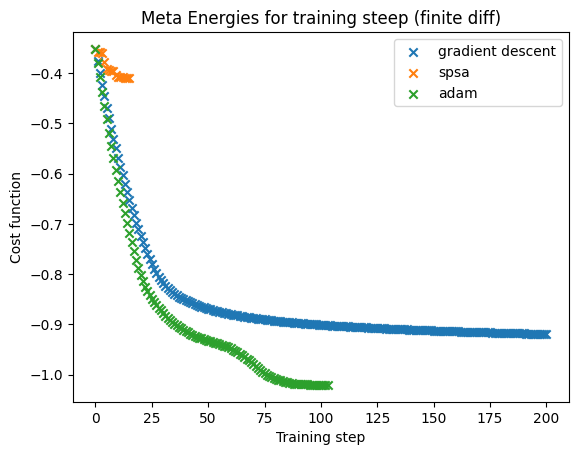

In [17]:
plt.scatter([i for i in range(len(TRAINING_ENERGIES['gradient_descent']['energies'][-1]))],TRAINING_ENERGIES['gradient_descent']['energies'][-1], label="gradient descent", marker='x')
plt.scatter([i for i in range(len(TRAINING_ENERGIES['spsa']['energies'][-1]))],TRAINING_ENERGIES['spsa']['energies'][-1], label="spsa", marker='x')
plt.scatter([i for i in range(len(TRAINING_ENERGIES['adam']['energies'][-1]))],TRAINING_ENERGIES['adam']['energies'][-1], label="adam", marker='x')

plt.legend()
plt.title('Meta Energies for training steep (finite diff)')
plt.ylabel('Cost function')
plt.xlabel('Training step')
plt.show

In [18]:
trained_energies = {"gradient_descent":{"energies":[], "opt_meta_runs_per_step":[]}, "spsa":{"energies":[], "opt_meta_runs_per_step":[]}, "adam":{"energies":[], "opt_meta_runs_per_step":[]}}

for count, d in enumerate(test_points):
    for k in trained_energies:
        if ENCODER == 1:
            encoded_params = linear_encoding(TRAINING_ENERGIES[k]["trained_meta_vars"][-1], d)
        else:
            encoded_params = gaussian_encoding(TRAINING_ENERGIES[k]["trained_meta_vars"][-1], d)
        energy= simplified_two_design(encoded_params,test_hamiltonians[count])
        trained_energies[k]["energies"].append(energy)

/opt/conda/envs/python39/lib/python3.9/site-packages/pennylane/math/utils.py:223: UserWarning: Contains tensors of types {'autograd', 'jax'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


<function matplotlib.pyplot.show(close=None, block=None)>

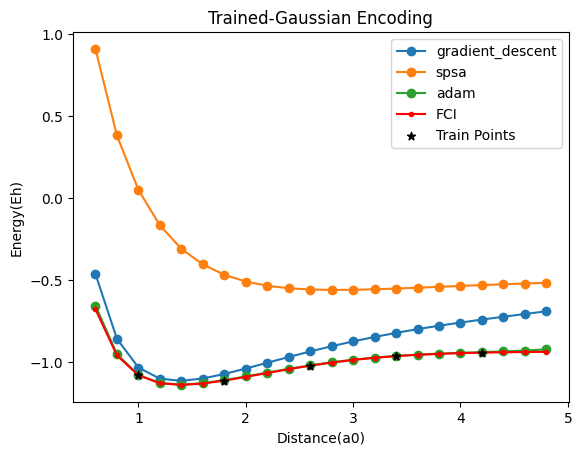

In [19]:
plt.plot(test_points, trained_energies["gradient_descent"]["energies"], label="gradient_descent", marker='o')
plt.plot(test_points, trained_energies["spsa"]["energies"], label="spsa", marker='o')
plt.plot(test_points, trained_energies["adam"]["energies"], label="adam", marker='o')
plt.plot(test_points, fci_energies, label="FCI", marker='.', color="r")
plt.scatter(train_points, [fci_energies[i] for i in train_points_indexes], zorder=99, label="Train Points", marker='*', color="black")


plt.legend()
plt.title('Trained-Gaussian Encoding')
plt.xlabel('Distance(a0)')
plt.ylabel('Energy(Eh)')
plt.show

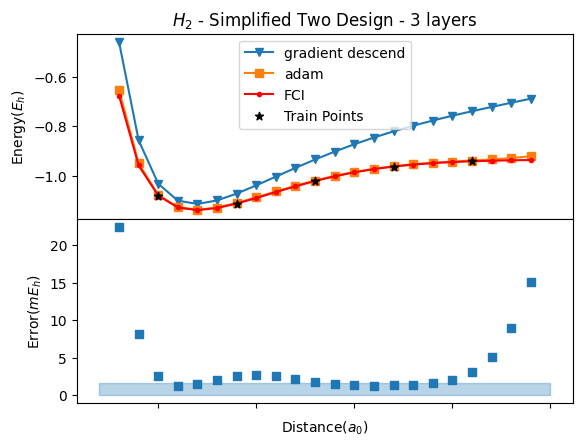

In [20]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

plt.subplots_adjust(hspace=0)

# ax1.plot(test_points, grad_descent_energies, label="gradient_descent", marker='s' , color=colors[0])
# ax1.plot(test_points, spsa_energies, label="spsa", marker='o', color=colors[1])
ax1.plot(test_points, trained_energies["gradient_descent"]["energies"], label="gradient descend", marker='v',)
ax1.plot(test_points, trained_energies["adam"]["energies"], label="adam", marker='s', )
ax1.plot(test_points, fci_energies, label="FCI", marker='.', color="r")
ax1.scatter(train_points, [fci_energies[i] for i in train_points_indexes], zorder=99, label="Train Points", marker='*', color="black")


ax1.legend()
ax1.set_title('$H_{2}$ - Simplified Two Design - '+str(LAYERS)+' layers')
ax1.set_ylabel('Energy($E_{h}$)')

# ax2.scatter(test_points, [np.abs(i-j) for i,j in zip(grad_descent_energies ,fci_energies)], label="gradient_descent", marker='s', color=colors[0])
# ax2.scatter(test_points, [np.abs(i-j) for i,j in zip(adam_energies ,fci_energies)], label="adam", marker='v', color=colors[2])
# ax2.scatter(test_points, [np.abs(i-j) for i,j in zip(trained_energies["gradient_descent"] ,fci_energies)], label="adam", marker='v')
ax2.scatter(test_points, [np.abs(i-j)*1000 for i,j in zip(trained_energies["adam"]["energies"] ,fci_energies)], label="adam", marker='s')


ax1.sharex(ax2)
ax1.set_xticklabels([])
ax2.autoscale() ## call autoscale if needed
ax2.fill_between([test_points[0]-0.2,test_points[-1]+0.2],1.6, color="#1f77b450")

# ax2.set_title('Error for each point')
ax2.set_xlabel('Distance($a_{0}$)')
ax2.set_ylabel('Error($mE_{h}$)')


plt.show()

In [21]:
opt_energies = []
for count, d in enumerate(test_points):
    for k in trained_energies:
        if ENCODER == 1:
            encoded_params = linear_encoding(TRAINING_ENERGIES[k]["trained_meta_vars"][-1], d)
        else:
            encoded_params = gaussian_encoding(TRAINING_ENERGIES[k]["trained_meta_vars"][-1], d)


    res_demon_adam = minimize(simplified_two_design, encoded_params, method = ham_adam, options = {'hamiltonian':test_hamiltonians[count], 'maxiter': 200, 'tol':1e-5, 'demon':True,'adamax':False, 'verbose':True})
    opt_energies.append(res_demon_adam.fun)
    trained_energies[k]["opt_meta_runs_per_step"].append(res_demon_adam.nit)    

ADAM - Step:  0  Cost:  -0.6632412523888164
ADAM - Step:  10  Cost:  -0.674069040545672
ADAM - Step:  20  Cost:  -0.6753182467331605
Finished ADAM training
ADAM - Step:  0  Cost:  -0.953142865521529
ADAM - Step:  10  Cost:  -0.9566155309436122
Finished ADAM training
ADAM - Step:  0  Cost:  -1.0768350751192008
ADAM - Step:  10  Cost:  -1.0782637343640806
Finished ADAM training
ADAM - Step:  0  Cost:  -1.1252794791562815
Finished ADAM training
ADAM - Step:  0  Cost:  -1.1359773961277992
Finished ADAM training
ADAM - Step:  0  Cost:  -1.127917471010857
ADAM - Step:  10  Cost:  -1.128241036158579
Finished ADAM training
ADAM - Step:  0  Cost:  -1.109863516840646
Finished ADAM training
ADAM - Step:  0  Cost:  -1.0873303784559962
Finished ADAM training
ADAM - Step:  0  Cost:  -1.0636046251521378
Finished ADAM training
ADAM - Step:  0  Cost:  -1.0404179866313878
Finished ADAM training
ADAM - Step:  0  Cost:  -1.0189947758841866
Finished ADAM training
ADAM - Step:  0  Cost:  -1.0002831272796486

In [22]:
opt_adam_energies = [energy[-1] for energy in opt_energies]
print(opt_adam_energies)

[tensor(-0.67556721, requires_grad=True), tensor(-0.95684293, requires_grad=True), tensor(-1.07826373, requires_grad=True), tensor(-1.12613016, requires_grad=True), tensor(-1.1364356, requires_grad=True), tensor(-1.12824104, requires_grad=True), tensor(-1.10996787, requires_grad=True), tensor(-1.08727559, requires_grad=True), tensor(-1.06394699, requires_grad=True), tensor(-1.04074728, requires_grad=True), tensor(-1.01935299, requires_grad=True), tensor(-1.00052365, requires_grad=True), tensor(-0.98466376, requires_grad=True), tensor(-0.97193984, requires_grad=True), tensor(-0.96145995, requires_grad=True), tensor(-0.95363577, requires_grad=True), tensor(-0.94767693, requires_grad=True), tensor(-0.94330964, requires_grad=True), tensor(-0.94043014, requires_grad=True), tensor(-0.93785171, requires_grad=True), tensor(-0.93631176, requires_grad=True), tensor(-0.93549847, requires_grad=True)]


<function matplotlib.pyplot.show(close=None, block=None)>

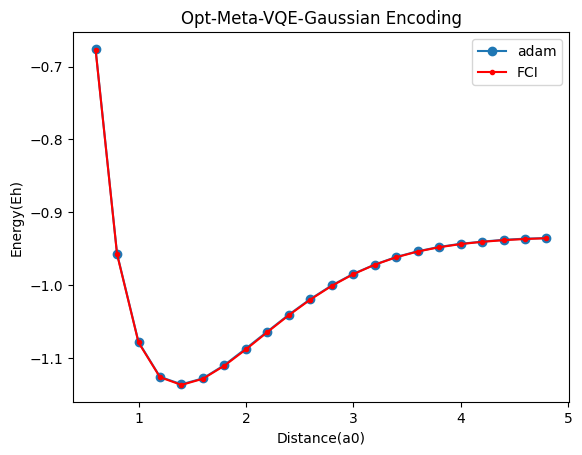

In [23]:
plt.plot(test_points, opt_adam_energies, label="adam", marker='o')
plt.plot(test_points, fci_energies, label="FCI", marker='.', color="r")


plt.legend()
plt.title('Opt-Meta-VQE-Gaussian Encoding')
plt.xlabel('Distance(a0)')
plt.ylabel('Energy(Eh)')
plt.show

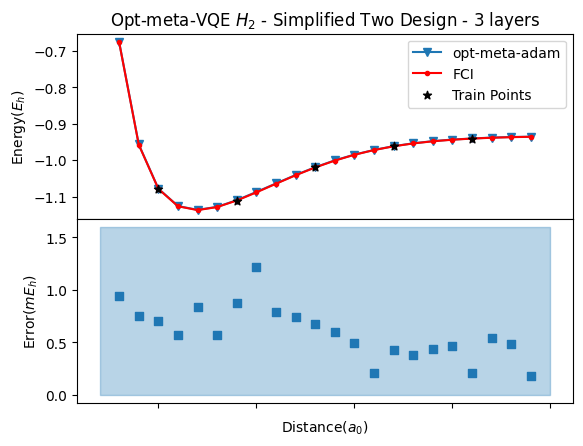

In [24]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

plt.subplots_adjust(hspace=0)

# ax1.plot(test_points, grad_descent_energies, label="gradient_descent", marker='s' , color=colors[0])
# ax1.plot(test_points, spsa_energies, label="spsa", marker='o', color=colors[1])
ax1.plot(test_points, opt_adam_energies, label="opt-meta-adam", marker='v',)
ax1.plot(test_points, fci_energies, label="FCI", marker='.', color="r")
ax1.scatter(train_points, [fci_energies[i] for i in train_points_indexes], zorder=99, label="Train Points", marker='*', color="black")


ax1.legend()
ax1.set_title('Opt-meta-VQE $H_{2}$ - Simplified Two Design - '+str(LAYERS)+' layers')
ax1.set_ylabel('Energy($E_{h}$)')

# ax2.scatter(test_points, [np.abs(i-j) for i,j in zip(grad_descent_energies ,fci_energies)], label="gradient_descent", marker='s', color=colors[0])
# ax2.scatter(test_points, [np.abs(i-j) for i,j in zip(adam_energies ,fci_energies)], label="adam", marker='v', color=colors[2])
# ax2.scatter(test_points, [np.abs(i-j) for i,j in zip(trained_energies["gradient_descent"] ,fci_energies)], label="adam", marker='v')
ax2.scatter(test_points, [np.abs(i-j)*1000 for i,j in zip(opt_adam_energies ,fci_energies)], label="adam", marker='s')


ax1.sharex(ax2)
ax1.set_xticklabels([])
ax2.autoscale() ## call autoscale if needed
ax2.fill_between([test_points[0]-0.2,test_points[-1]+0.2],1.6, color="#1f77b450")

# ax2.set_title('Error for each point')
ax2.set_xlabel('Distance($a_{0}$)')
ax2.set_ylabel('Error($mE_{h}$)')


plt.show()

In [25]:
import json
import numpy as np

class NumpyEncoder(json.JSONEncoder):
    """ Special json encoder for numpy types """
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray) or isinstance(obj, jnp.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)
    
with open(f'exp_runs/simplified2design_{LAYERS}layers_{GRADIENT_METHOD}.json', 'w') as f:
    f.write(json.dumps({
        "layers": LAYERS,
        "results": TRAINING_ENERGIES,
        "meta":trained_energies,
        "opt_meta":opt_adam_energies

    }
    , indent=4, cls=NumpyEncoder))   